In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from json import loads as json_loads

In [2]:
# RIPE ATLAS, Ping measurements, hourly datasets, January 20, 2023, 12:00.
# Source (ca. 1.4GB): https://data-store.ripe.net/datasets/atlas-daily-dumps/2023-01-20/ping-2023-01-20T1200.bz2
ripe_ping_file = "/PRIVATE_PATH/ping-2023-01-20T1200"

# Dataset produced by this Notebook of only select and approximated latency values from above dataset.
latencies_file = "/PRIVATE_PATH/ripe-atlas_latencies_2023-01-20T1200"

In [3]:
probeid_to_dstaddr = dict()
probeid_to_from = dict()
probeid_used_cnt = dict()

measurements_total = 0
measurements_selected = 0

with open(ripe_ping_file, "r", encoding = "utf-8") as ripe_ping_fp:
    
    with open(latencies_file, "w", encoding = "utf-8") as latencies_fp:
        
        latencies_fp.write(f"latency_ms\n")
    
        for ripe_ping_raw in ripe_ping_fp:

            # Parse current line from RIPE ATLAS Ping dataset as JSON.
            ripe_ping = json_loads(ripe_ping_raw)
            measurements_total += 1

            # Skip over lines that don't contain all keys we require.
            if not (("fw" in ripe_ping)
                    and ("af" in ripe_ping)
                    and ("type" in ripe_ping)
                    and ("msm_name" in ripe_ping)
                    and ("proto" in ripe_ping)
                    and ("lts" in ripe_ping)
                    and ("prb_id" in ripe_ping)
                    and ("from" in ripe_ping)
                    and ("dst_addr" in ripe_ping)
                    and ("dst_name" in ripe_ping)
                    and ("sent" in ripe_ping)
                    and ("rcvd" in ripe_ping)
                    and ("min" in ripe_ping)
                    and ("max" in ripe_ping)
                    and ("avg" in ripe_ping)
                    and ("result" in ripe_ping)):
                continue
            
            # 'src_addr' apparently can be a private-network IP address.
            # Theoretically, anycast addresses can be used as source addresses.
            # Thus, we rely on 'prb_id' (probe identifier) as the unique host criterion.
            # The RTT measurements ('result'['rtt'], 'min', 'max', 'avg') are in milliseconds.
            # Source: https://atlas.ripe.net/docs/apis/result-format/#version-5000-ping-v6-ping

            if ((ripe_ping["fw"] > 5000)
                and (ripe_ping["af"] == 4)
                and (ripe_ping["type"] == "ping")
                and (ripe_ping["msm_name"] == "Ping")
                and (ripe_ping["proto"] == "ICMP")
                and (ripe_ping["lts"] != -1)
                and (ripe_ping["from"] != "")
                and (ripe_ping["from"] != ripe_ping["dst_addr"])
                and (ripe_ping["from"] != ripe_ping["dst_name"])
                and (ripe_ping["sent"] >= 3)
                and (ripe_ping["sent"] == ripe_ping["rcvd"])
                and (ripe_ping["min"] > 0.0)
                and (ripe_ping["max"] > 0.0)
                and (ripe_ping["avg"] > 0.0)
                and (all("rtt" in measurement for measurement in ripe_ping["result"]))):
                
                probeid = ripe_ping["prb_id"]
                fromaddr = ripe_ping["from"]
                dstaddr = ripe_ping["dst_addr"]
                
                # Build key that identifies this logical link: 'probe_identifier=>destination_address'.
                # This means that we allow measurements from the two sides of the same logical connection
                # to be present in the dataset even though we already included the other direction.
                key_probe = f"{probeid}=>{dstaddr}"
                
                # Make sure we haven't seen this logical link before.
                if key_probe not in probeid_to_dstaddr:
                    
                    # Skip over measurements for which we have seen a different 'from'
                    # IP address in an already considered prior measurement.
                    if ((probeid in probeid_to_from)
                        and (fromaddr != probeid_to_from[probeid])):
                        continue
                    
                    # Only consider the first 3 RTT measurements.
                    for measurement in ripe_ping["result"][:3]:
                    
                        # Simplifying assumption: RTT / 2.0 is a sufficient approximation for latency.
                        latency = measurement["rtt"] / 2.0

                        # Write latency approximated from RTT measurement to the end of the file.
                        latencies_fp.write(f"{latency:f}\n")
                    
                    # Increment counter of how many measurements from the original dataset we use.
                    measurements_selected += 1
                    
                    # Note down that we considered a ping from this probe to this destination.
                    probeid_to_dstaddr[key_probe] = True
                    probeid_to_from[probeid] = fromaddr
                    
                    # Keep count of how often we have included a measurement from this probe.
                    if probeid not in probeid_used_cnt:
                        probeid_used_cnt[probeid] = 0
                    probeid_used_cnt[probeid] += 1

print(f"{measurements_total=:,}")
print(f"{measurements_selected=:,}")
print(f"{len(probeid_used_cnt)=:,} (number of contributing probes)")

measurements_total=30,411,043
measurements_selected=1,124,387
len(probeid_used_cnt)=11,064 (number of contributing probes)


In [4]:
# Create new DataFrame from the Python dictionary of probe_id => included_measurements_count.
df_probeid = pd.DataFrame.from_dict(data = probeid_used_cnt, orient = "index", columns = ["cnt"])

# Sort them in-place in descending order, mostly for us to be able to see their range via head() and tail().
df_probeid.sort_values(by = ["cnt"], ascending = False, inplace = True)

In [5]:
df_probeid.head(10)

,cnt
6993,1152
6779,1142
6471,855
6090,852
6616,850
6431,849
6843,848
6695,848
6382,847
6232,844


In [6]:
df_probeid.tail(10)

,cnt
61183,1
30637,1
23451,1
1002933,1
1002931,1
1002407,1
1002540,1
1002543,1
1002988,1
1002917,1


In [7]:
df_probeid.describe()

,cnt
count,11064.000000
mean,101.625723
std,199.398200
min,1.000000
25%,34.000000
50%,42.000000
75%,64.000000
max,1152.000000


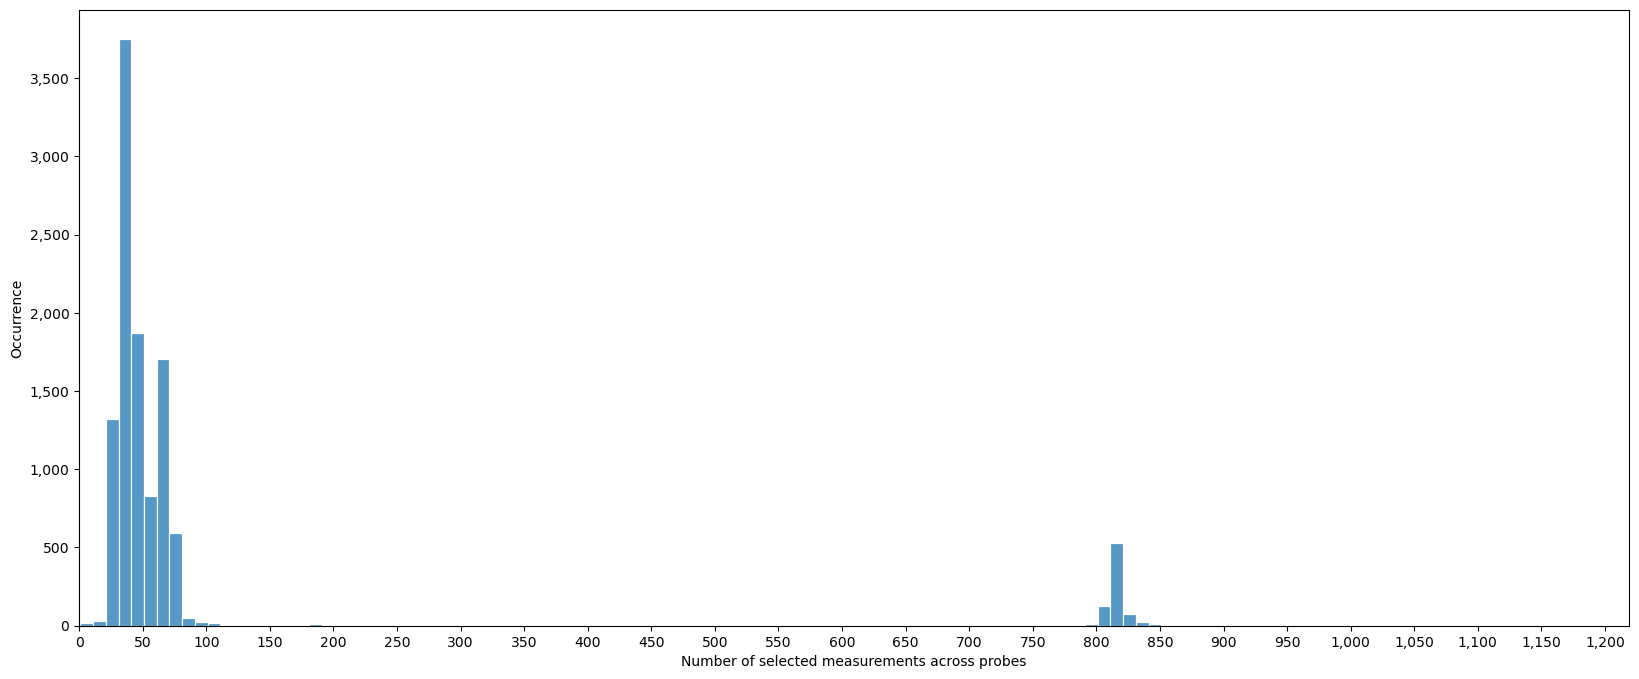

In [8]:
fig, ax = plt.subplots(figsize=(20, 8))

# Set basic figure style.
sns.set()
sns.set(style="whitegrid", font_scale=1.5)
sns.set_style({"font.family": "Fira Sans Condensed"})

# Plot histogram of number of included measurements across all probes with a bin width of 10.
plot_hist = sns.histplot(data = df_probeid, x = "cnt", binwidth = 10)

# Bottom left of plot starts at (0, 0).
plot_hist.set_xlim(left = 0)
plot_hist.set_ylim(bottom = 0)
plot_hist.set_xticks(np.arange(start = 0, stop = (df_probeid.max()["cnt"] + 50), step = 50))

# Format labels with thousands indicator.
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda obs, pos: f"{round(obs):,}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda count, pos: f"{round(count):,}"))

# Label axes usefully.
plt.xlabel("Number of selected measurements across probes")
plt.ylabel("Occurrence")

plt.show()

In [3]:
# Read in above-created file containing only the first three latency approximation
# values from each measurement in the RIPE ATLAS Ping hourly dataset.
df_lat_all = pd.read_table(latencies_file, header = 0)

# Sort them in-place, mostly for us to be able to see their range via head() and tail().
df_lat_all.sort_values(by = ["latency_ms"], inplace = True)

In [4]:
# We see some very high latencies in interval [P99, P100] of this dataset, e.g.,
# latencies beyond 4,000 ms. These are likely outliers and not representative of
# well-connected server-to-server networks.
df_lat_all[df_lat_all["latency_ms"] > df_lat_all["latency_ms"].quantile(0.99)].describe()

,latency_ms
count,33732.000000
mean,198.923830
std,69.911372
min,172.854780
25%,178.583963
50%,186.759316
75%,200.215268
max,4601.289543


In [5]:
# Thus, we exclude the long tail of this dataset from further consideration
# by focusing only on P99 of the dataset.
df_lat = df_lat_all[df_lat_all["latency_ms"] <= df_lat_all["latency_ms"].quantile(0.99)]

In [6]:
df_lat.head(10)

,latency_ms
165747,0.019768
3163989,0.020084
1892282,0.023200
1892281,0.026995
1349929,0.029747
1349928,0.032169
165748,0.034041
165749,0.040785
1892280,0.045665
3163990,0.050701


In [7]:
df_lat.tail(10)

,latency_ms
3077512,172.848832
1877998,172.849106
2720550,172.849122
3163174,172.849197
1324103,172.849693
2185463,172.850605
533710,172.851471
1141637,172.851813
808459,172.851967
2405441,172.854694


In [8]:
df_lat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3339429 entries, 165747 to 2405441
Data columns (total 1 columns):
 #   Column      Dtype  
---  ------      -----  
 0   latency_ms  float64
dtypes: float64(1)
memory usage: 51.0 MB


In [9]:
df_lat.describe()

,latency_ms
count,3.339429e+06
mean,5.110260e+01
std,4.349044e+01
min,1.976800e-02
25%,1.245445e+01
50%,4.056188e+01
75%,8.245994e+01
max,1.728547e+02


In [10]:
df_lat.mean()

latency_ms    51.102603
dtype: float64

PDFCROP 1.40, 2020/06/06 - Copyright (c) 2002-2020 by Heiko Oberdiek, Oberdiek Package Support Group.
==> 1 page written on `ripe-atlas_latencies_histogram_2023-01-20T1200-crop.pdf'.


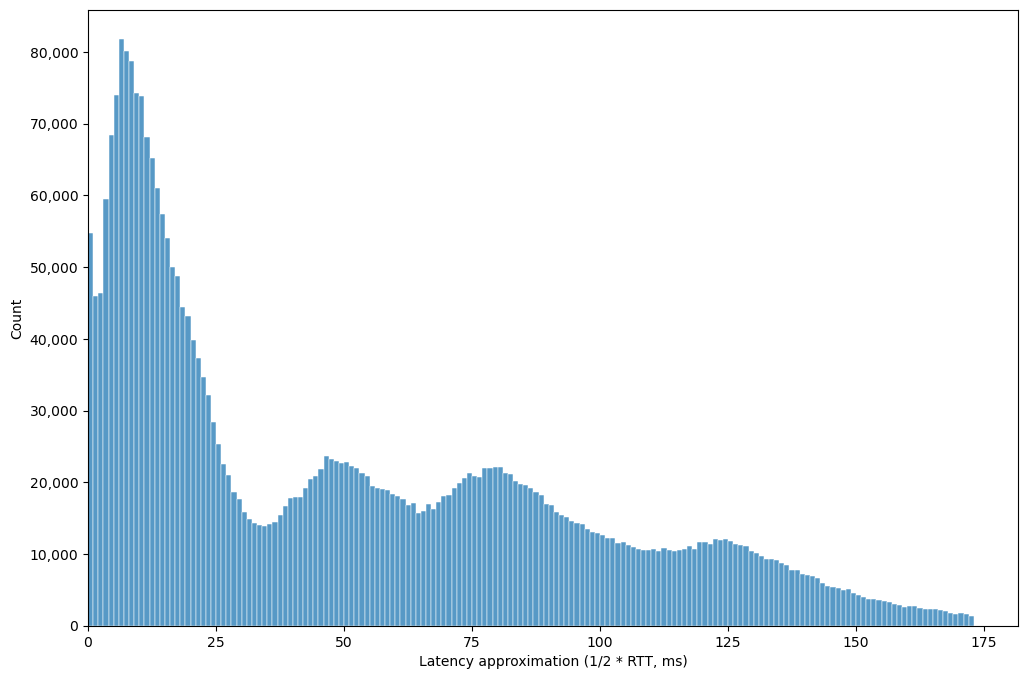

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

# Set basic figure style.
sns.set()
sns.set(style="whitegrid", font_scale=1.5)
sns.set_style({"font.family": "Fira Sans Condensed"})

# Plot histogram of latency approximations with a bin width of 1ms.
plot_hist = sns.histplot(data = df_lat, x = "latency_ms", binwidth = 1)

# Bottom left of plot starts at (0, 0).
plot_hist.set_xlim(left = 0)
plot_hist.set_ylim(bottom = 0)

# Format y-axis labels with thousands indicator.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda count, pos: f"{round(count):,}"))

# Label axes usefully.
plt.xlabel("Latency approximation (1/2 * RTT, ms)")
plt.ylabel("Count")

# Save and postprocess figure.
plt.savefig("ripe-atlas_latencies_histogram_2023-01-20T1200.pdf", bbox_inches="tight")
! pdfcrop --margin 0 ripe-atlas_latencies_histogram_2023-01-20T1200.pdf
! mv ripe-atlas_latencies_histogram_2023-01-20T1200-crop.pdf ripe-atlas_latencies_histogram_2023-01-20T1200.pdf

In [12]:
# Convert Pandas DataSeries to NumPy array.
lat_data = df_lat.to_numpy(copy = True)

In [13]:
print(f"{lat_data=}\n")
print(f"{len(lat_data)=:,}\n")
print(f"{lat_data.mean()=}")

lat_data=array([[1.97680000e-02],
       [2.00840000e-02],
       [2.32000000e-02],
       ...,
       [1.72851813e+02],
       [1.72851967e+02],
       [1.72854694e+02]])

len(lat_data)=3,339,429

lat_data.mean()=51.102603395457166


In [14]:
# Given that we'll be using the output of this Notebook in the context
# of latencies in seconds, convert all latencies correspondingly.
lat_data_seconds = lat_data / 1000.0

In [15]:
print(f"{lat_data_seconds=}\n")
print(f"{len(lat_data_seconds)=:,}\n")
print(f"{lat_data_seconds.mean()=}")

lat_data_seconds=array([[1.97680000e-05],
       [2.00840000e-05],
       [2.32000000e-05],
       ...,
       [1.72851813e-01],
       [1.72851967e-01],
       [1.72854694e-01]])

len(lat_data_seconds)=3,339,429

lat_data_seconds.mean()=0.05110260339545711


In [16]:
# Calculate NumPy histogram of latency values over 100 bins.
lat_weights, lat_bin_edges = np.histogram(lat_data_seconds, bins = 100, density = True)

In [17]:
print(f"{lat_weights=}\n")
print(f"{len(lat_weights)=}")

lat_weights=array([15.24836798, 14.59171565, 20.16425096, 23.43451815, 23.92536143,
       22.45854914, 20.99953351, 18.94762493, 17.02756659, 15.15688713,
       13.8091039 , 12.60980379, 11.01512621,  9.78931745,  7.9584876 ,
        6.58384919,  5.7007471 ,  4.9323426 ,  4.34048921,  4.17641276,
        4.27257161,  4.54008379,  5.14423859,  5.36462427,  5.68983177,
        6.20181268,  6.75000475,  7.0053888 ,  6.81047221,  6.71206099,
        6.51991655,  6.20908956,  5.78425803,  5.70126688,  5.4697926 ,
        5.32026992,  5.07891987,  4.74089119,  4.99956716,  5.06488588,
        5.41348337,  5.79742573,  6.16525499,  6.3154707 ,  6.35272143,
        6.58021075,  6.63201524,  6.33002448,  5.97848158,  5.89081243,
        5.60043003,  5.26534676,  4.94828244,  4.62775294,  4.4563996 ,
        4.24935487,  4.0603291 ,  3.85345763,  3.71381072,  3.56636715,
        3.46795593,  3.30561207,  3.18571671,  3.1874493 ,  3.14101584,
        3.18086545,  3.15470332,  3.2298978 ,  3.295

In [18]:
print(f"{lat_bin_edges=}\n")
print(f"{len(lat_bin_edges)=}")

lat_bin_edges=array([1.97680000e-05, 1.74811726e-03, 3.47646652e-03, 5.20481578e-03,
       6.93316504e-03, 8.66151430e-03, 1.03898636e-02, 1.21182128e-02,
       1.38465621e-02, 1.55749113e-02, 1.73032606e-02, 1.90316099e-02,
       2.07599591e-02, 2.24883084e-02, 2.42166576e-02, 2.59450069e-02,
       2.76733562e-02, 2.94017054e-02, 3.11300547e-02, 3.28584039e-02,
       3.45867532e-02, 3.63151025e-02, 3.80434517e-02, 3.97718010e-02,
       4.15001502e-02, 4.32284995e-02, 4.49568488e-02, 4.66851980e-02,
       4.84135473e-02, 5.01418965e-02, 5.18702458e-02, 5.35985951e-02,
       5.53269443e-02, 5.70552936e-02, 5.87836428e-02, 6.05119921e-02,
       6.22403414e-02, 6.39686906e-02, 6.56970399e-02, 6.74253891e-02,
       6.91537384e-02, 7.08820877e-02, 7.26104369e-02, 7.43387862e-02,
       7.60671354e-02, 7.77954847e-02, 7.95238340e-02, 8.12521832e-02,
       8.29805325e-02, 8.47088817e-02, 8.64372310e-02, 8.81655803e-02,
       8.98939295e-02, 9.16222788e-02, 9.33506280e-02, 9.507897

In [19]:
# Select all lower bin edges as the list of weighted choices to draw from.
lat_choices = lat_bin_edges[:(len(lat_bin_edges) - 1)]

In [20]:
print(f"{lat_choices=}\n")
print(f"{len(lat_choices)=}")

lat_choices=array([1.97680000e-05, 1.74811726e-03, 3.47646652e-03, 5.20481578e-03,
       6.93316504e-03, 8.66151430e-03, 1.03898636e-02, 1.21182128e-02,
       1.38465621e-02, 1.55749113e-02, 1.73032606e-02, 1.90316099e-02,
       2.07599591e-02, 2.24883084e-02, 2.42166576e-02, 2.59450069e-02,
       2.76733562e-02, 2.94017054e-02, 3.11300547e-02, 3.28584039e-02,
       3.45867532e-02, 3.63151025e-02, 3.80434517e-02, 3.97718010e-02,
       4.15001502e-02, 4.32284995e-02, 4.49568488e-02, 4.66851980e-02,
       4.84135473e-02, 5.01418965e-02, 5.18702458e-02, 5.35985951e-02,
       5.53269443e-02, 5.70552936e-02, 5.87836428e-02, 6.05119921e-02,
       6.22403414e-02, 6.39686906e-02, 6.56970399e-02, 6.74253891e-02,
       6.91537384e-02, 7.08820877e-02, 7.26104369e-02, 7.43387862e-02,
       7.60671354e-02, 7.77954847e-02, 7.95238340e-02, 8.12521832e-02,
       8.29805325e-02, 8.47088817e-02, 8.64372310e-02, 8.81655803e-02,
       8.98939295e-02, 9.16222788e-02, 9.33506280e-02, 9.50789773

In [21]:
# Create pairs of choice values with their respective weight.
lat_choice_weight = np.column_stack((lat_choices, lat_weights))

In [22]:
print(f"{lat_choice_weight=}\n")
print(f"{len(lat_choice_weight)=}")

lat_choice_weight=array([[1.97680000e-05, 1.52483680e+01],
       [1.74811726e-03, 1.45917157e+01],
       [3.47646652e-03, 2.01642510e+01],
       [5.20481578e-03, 2.34345182e+01],
       [6.93316504e-03, 2.39253614e+01],
       [8.66151430e-03, 2.24585491e+01],
       [1.03898636e-02, 2.09995335e+01],
       [1.21182128e-02, 1.89476249e+01],
       [1.38465621e-02, 1.70275666e+01],
       [1.55749113e-02, 1.51568871e+01],
       [1.73032606e-02, 1.38091039e+01],
       [1.90316099e-02, 1.26098038e+01],
       [2.07599591e-02, 1.10151262e+01],
       [2.24883084e-02, 9.78931745e+00],
       [2.42166576e-02, 7.95848760e+00],
       [2.59450069e-02, 6.58384919e+00],
       [2.76733562e-02, 5.70074710e+00],
       [2.94017054e-02, 4.93234260e+00],
       [3.11300547e-02, 4.34048921e+00],
       [3.28584039e-02, 4.17641276e+00],
       [3.45867532e-02, 4.27257161e+00],
       [3.63151025e-02, 4.54008379e+00],
       [3.80434517e-02, 5.14423859e+00],
       [3.97718010e-02, 5.36462427e+00]

In [23]:
# Write weighted choices to file in a format almost immediately usable in Rust.
np.savetxt(
    "ripe-atlas_latencies_2023-01-20T1200_weighted-choices",
    lat_choice_weight,
    fmt = ("(%.12f", "%.16f),"),
    delimiter = ", "
)

In [26]:
# Print width of each bin so that we can sample uniformly at random from [0, width).
diffs = np.diff(lat_bin_edges)
width_raw = np.mean(diffs)

print(f"{width_raw:.16f}")
print(width_raw <= diffs)
print()

width_adj = 0.00172834925
print(f"{width_adj:.16f}")
print(width_adj <= diffs)
print()

print(f"Thus, use this adjusted \"safe\" width: {width_adj}")

0.0017283492600000
[ True False  True False False  True False False False False  True  True
 False  True False  True  True False  True False  True False False  True
 False False False  True False False  True False False  True False False
  True False False False False  True False False False False False  True
 False False False False False False  True False False False False False
  True False False False False False False  True False False False False
 False  True False  True  True False  True False  True False  True  True
 False  True False  True False  True  True False  True False  True  True
 False  True False  True]

0.0017283492500000
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  Tru